# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states.

We call this `time travel`.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk langgraph-prebuilt

In [2]:
%pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
def multiply(a: int, b: int) -> int:
  """Multiply a and b

  Args:
      a: first int
      b: second int
  """
  return a * b

def add(a: int, b: int) -> int:
  """Adds a and b

  Args:
      a: first int
      b: second int
  """
  return a + b

def divide(a: int, b: int) -> int:
  """Multiply a and b

  Args:
      a: first int
      b: second int
  """
  return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0)
llm_with_tools = llm.bind_tools(tools)

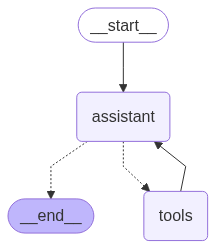

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
  return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


Let's run it, as before

In [6]:
# Input
initial_input = {"messages":HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable":{"thread_id":"1"}}

# Run the Graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (4d45bc29-7b3d-4423-8314-2ccc70e08f3c)
 Call ID: 4d45bc29-7b3d-4423-8314-2ccc70e08f3c
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [7]:
graph.get_state({"configurable":{"thread_id":"1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--513fe247-0e10-4306-9a4f-cd2a0ab2c48c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '4d45bc29-7b3d-4423-8314-2ccc70e08f3c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 163, 'output_tokens': 80, 'total_tokens': 243, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 62}}), ToolMessage(content='6', name='multiply', id='135d9d24-47ee-4e05-ae30-f2dd63eadd31', tool_call_id='4d45bc29-7b3d-4423-8314-2ccc70e08f3c'), AIMessage(content='The result of multiplying 2 and 3 is 6.', additio

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [8]:
all_states = [ s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

The first element is the current state, just as we got from `get_state`.

In [10]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084db6-4a9d-6189-8000-8c7f31e7e301'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-29T13:23:47.004011+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084db6-4a98-636a-bfff-386add1b2f44'}}, tasks=(PregelTask(id='22b0d484-5558-af34-40ae-8ac3d929e460', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, i

Everything above we can visualize here:

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [11]:
to_replay = all_states[-2]

In [12]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084db6-4a9d-6189-8000-8c7f31e7e301'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-29T13:23:47.004011+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084db6-4a98-636a-bfff-386add1b2f44'}}, tasks=(PregelTask(id='22b0d484-5558-af34-40ae-8ac3d929e460', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, i

Look at the state

In [13]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]}

We can see the next node to call

In [14]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084db6-4a9d-6189-8000-8c7f31e7e301'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (e6c0c2db-8d12-4777-9877-69f7b8b76dcd)
 Call ID: e6c0c2db-8d12-4777-9877-69f7b8b76dcd
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


Now, we can see our current state after the agent re-ran

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [17]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]

Again, we have the config


In [18]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084db6-4a9d-6189-8000-8c7f31e7e301'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied.

Remember how our reducer on `messages` works:

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [19]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

In [20]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084dc6-2fbd-6cc4-8001-2df5b5fafd87'}}

This creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [21]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]

In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084dc6-2fbd-6cc4-8001-2df5b5fafd87'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-29T13:30:53.682990+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f084db6-4a9d-6189-8000-8c7f31e7e301'}}, tasks=(PregelTask(id='5114d311-887c-612a-9e07-2e89036ba56c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (4f8d1a65-d0a1-4aa2-9141-249c54a5e4b2)
 Call ID: 4f8d1a65-d0a1-4aa2-9141-249c54a5e4b2
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is 15.


Now, we can see the current state is the end of our agent run.

In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='28f04088-e131-48c9-9062-3eff8b006edd'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 5.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--14a8b0b4-cd50-43fc-9c62-60b472668cff-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5.0, 'b': 3.0}, 'id': '4f8d1a65-d0a1-4aa2-9141-249c54a5e4b2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 163, 'output_tokens': 78, 'total_tokens': 241, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 60}}), ToolMessage(content='15', name='multiply', id='d3d61d19-568b-4f4f-ac55-f5f4d51a324c', tool_call_id='4f8d1a65-d0a1-4aa2-9141-249c54a5e4b2'), AIMessage(content='The product of 5 and 3 is 15.', additional_kwarg